In [1]:
# To support both python 2 and python 3
# 让这份笔记同步支持 python 2 和 python 3
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
#使用statsmodels便于统计分析数据
import statsmodels.api as sm
import statsmodels.formula.api as smf
#使用sklearn便于预测（机器学习）
from sklearn import linear_model
#使用patsy便于生成模型
import patsy

**10. We now use boosting to predict Salary in the Hitters data set.
(a) Remove the observations for whom the salary information is
unknown, and then log-transform the salaries.**

In [3]:
Hitters = pd.read_csv("data/Hitters.csv").dropna()
Hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [4]:
columns = '1'
for column in Hitters.columns:
    columns = columns + '+' + column
y,X = patsy.dmatrices('np.log(Salary) ~ {} - Salary'.format(columns), Hitters, return_type = 'dataframe')
X.drop('Intercept',axis = 1,inplace= True)

**(b) Create a training set consisting of the first 200 observations, and
a test set consisting of the remaining observations.**

In [5]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(Hitters, train_size = 200, random_state = 1)
y_test,X_test = patsy.dmatrices('np.log(Salary) ~ {} - Salary'.format(columns), test_set, return_type = 'dataframe')
y_train,X_train = patsy.dmatrices('np.log(Salary) ~ {} - Salary'.format(columns), train_set, return_type = 'dataframe')
X_test.drop('Intercept',axis = 1,inplace= True)
X_train.drop('Intercept',axis = 1,inplace= True)

**(c) Perform boosting on the training set with 1,000 trees for a range
of values of the shrinkage parameter λ. Produce a plot with
different shrinkage values on the x-axis and the corresponding
training set MSE on the y-axis.**

In [6]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
lambda_range = 10 ** np.linspace(-4,0,33)
test_mse = []
train_mse = []
for learning_rate in lambda_range:
    gb_reg = GradientBoostingRegressor(n_estimators = 1000,learning_rate=learning_rate,random_state = 1)
    gb_reg.fit(X_train,y_train.values.flatten())
    train_mse.append(mean_squared_error(y_train,gb_reg.predict(X_train)))
    test_mse.append(mean_squared_error(y_test,gb_reg.predict(X_test)))

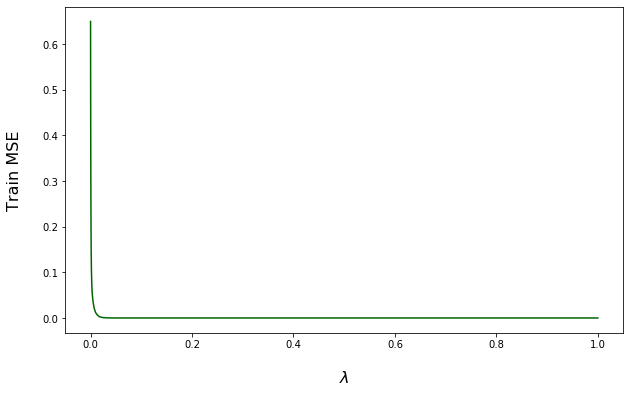

In [7]:
plt.figure(figsize=(10,6))
plt.plot(lambda_range,train_mse,color = 'darkgreen')
plt.xlabel(r"$\lambda$", fontsize = 16,labelpad =20)
plt.ylabel('Train MSE', fontsize = 16,labelpad =20)
plt.show()

**(d) Produce a plot with different shrinkage values on the x-axis and
the corresponding test set MSE on the y-axis.**

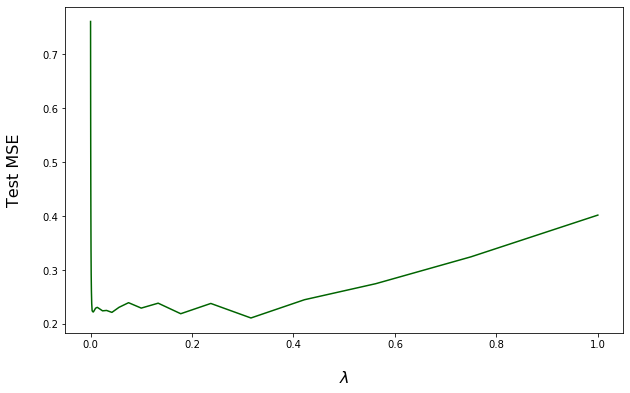

In [8]:
plt.figure(figsize=(10,6))
plt.plot(lambda_range,test_mse,color = 'darkgreen')
plt.xlabel(r"$\lambda$", fontsize = 16,labelpad =20)
plt.ylabel('Test MSE', fontsize = 16,labelpad =20)
plt.show()

In [9]:
gb_test_mse = pd.DataFrame(test_mse,index = lambda_range,columns = ['test_mse'])
gb_test_mse.index.name = 'learning_rate'
gb_test_mse.sort_values('test_mse').iloc[:3]

,test_mse
learning_rate,
0.316228,0.211025
0.177828,0.218915
0.042170,0.221410


In [10]:
gb_test_mse_min = float(gb_test_mse.min())

**(e) Compare the test MSE of boosting to the test MSE that results
from applying two of the regression approaches seen in
Chapters 3 and 6.**

In [11]:
#方法1.简单线性回归(Chapters 3)
lin = linear_model.LinearRegression()
lin.fit(X_train,y_train)
lin_test_mse = mean_squared_error(y_test,lin.predict(X_test))
lin_test_mse

0.4526388884726705

In [12]:
#方法2.最优子集法( Chapters 6)
from sklearn.feature_selection import RFECV
estimator = linear_model.LinearRegression()
selector = RFECV(estimator, step=1, cv=10)
selector = selector.fit(X_train,y_train.values.flatten())
selector_test_mse = mean_squared_error(y_test,selector.predict(X_test))
selector_test_mse

0.46989930096239724

In [13]:
selector.ranking_

array([ 1,  1,  1,  1,  1,  1,  1,  6,  1,  1, 10,  7,  3, 11,  5,  4,  8,
        9,  2])

In [14]:
#方法3.岭回归方法( Chapters 6)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
std_scaler = StandardScaler(with_mean=False)
std_scaler.fit(X_train)
X_train_Standard = std_scaler.transform(X_train)
alpha_log_range = np.linspace(3, -3, 100)
param_grid = [
{'alpha': 10 ** alpha_log_range },
]
ridge_reg = Ridge(random_state = 1)
ridge_grid_search = GridSearchCV(ridge_reg, param_grid, cv = 10, scoring='neg_mean_squared_error')
ridge_grid_search.fit(X_train_Standard ,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=1,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([1.00000000e+03, 8.69749003e+02, 7.56463328e+02, 6.57933225e+02,
       5.72236766e+02, 4.97702356e+02, 4.32876128e+02, 3.76493581e+02,
       3.27454916e...
       1.41747416e-02, 1.23284674e-02, 1.07226722e-02, 9.32603347e-03,
       8.11130831e-03, 7.05480231e-03, 6.13590727e-03, 5.33669923e-03,
       4.64158883e-03, 4.03701726e-03, 3.51119173e-03, 3.05385551e-03,
       2.65608778e-03, 2.31012970e-03, 2.00923300e-03, 1.74752840e-03,
       1.51991108e-03, 1.32194115e-03, 1.14975700e-03, 1.00000000e-03])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

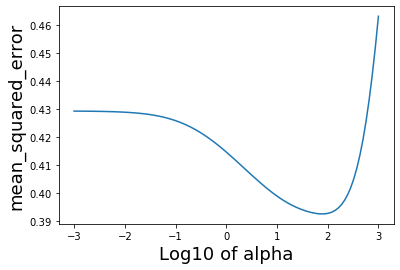

In [15]:
plt.plot(alpha_log_range,-ridge_grid_search.cv_results_["mean_test_score"])
plt.xlabel("Log10 of alpha", fontsize=18)
plt.ylabel("mean_squared_error", fontsize=18)
plt.show()

In [16]:
X_test_Standard = std_scaler.transform(X_test)
y_predictions_ridge = ridge_grid_search.predict(X_test_Standard)
test_mse_ridge = mean_squared_error(y_test, y_predictions_ridge)
test_mse_ridge

0.47601352868127345

In [17]:
#方法3.LASSSO回归方法( Chapters 6)
from sklearn.linear_model import Lasso
lasso_reg = Lasso(random_state = 1)
lasso_grid_search = GridSearchCV(lasso_reg, param_grid, cv = 10, scoring='neg_mean_squared_error')
lasso_grid_search.fit(X_train_Standard ,y_train)

c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02141313831406677, tolerance: 0.013506389545303206
  positive)
c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.026850388135500225, tolerance: 0.014340539785231657
  positive)
c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04173132717028949, tolerance: 0.013506389545303206
  positive)
c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_mode

GridSearchCV(cv=10, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=1,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([1.00000000e+03, 8.69749003e+02, 7.56463328e+02, 6.57933225e+02,
       5.72236766e+02, 4...
       1.41747416e-02, 1.23284674e-02, 1.07226722e-02, 9.32603347e-03,
       8.11130831e-03, 7.05480231e-03, 6.13590727e-03, 5.33669923e-03,
       4.64158883e-03, 4.03701726e-03, 3.51119173e-03, 3.05385551e-03,
       2.65608778e-03, 2.31012970e-03, 2.00923300e-03, 1.74752840e-03,
       1.51991108e-03, 1.32194115e-03, 1.14975700e-03, 1.00000000e-03])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

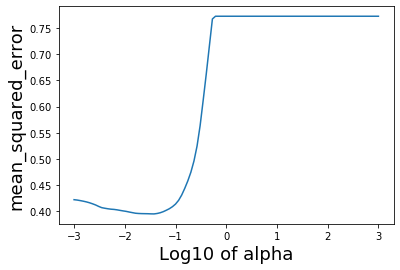

In [18]:
plt.plot(alpha_log_range,-lasso_grid_search.cv_results_["mean_test_score"])
plt.xlabel("Log10 of alpha", fontsize=18)
plt.ylabel("mean_squared_error", fontsize=18)
plt.show()

In [19]:
y_predictions_lasso = lasso_grid_search.predict(X_test_Standard)
test_mse_lasso = mean_squared_error(y_test, y_predictions_lasso)
test_mse_lasso

0.4806103646865291

In [20]:
Hitters.shape

(263, 20)

In [21]:
#方法4.PCA方法( Chapters 6)
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
pca_lr = Pipeline([
("pca", PCA()),
("lr", linear_model.LinearRegression())
])
param_grid = [
{'pca__n_components': np.arange(1,20) },
]
pca_grid_search = GridSearchCV(pca_lr, param_grid, cv = 10, scoring='neg_mean_squared_error')
pca_grid_search.fit(X_train_Standard ,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('lr',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'pca__n_components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 1

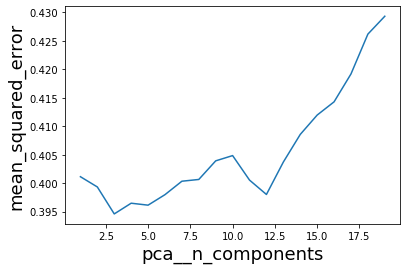

In [22]:
plt.plot(np.arange(1,20),-pca_grid_search.cv_results_["mean_test_score"])
plt.xlabel("pca__n_components", fontsize=18)
plt.ylabel("mean_squared_error", fontsize=18)
plt.show()

In [23]:
y_predictions_pca = pca_grid_search.predict(X_test_Standard)
test_mse_pca = mean_squared_error(y_test, y_predictions_pca)
test_mse_pca

0.5073891035043048

In [24]:
#方法5.PLS方法( Chapters 6)
from sklearn.cross_decomposition import PLSRegression
np.random.seed(1)
param_grid = [
{'n_components': np.arange(1,20) },
]
pls = PLSRegression()
pls_grid_search = GridSearchCV(pls, param_grid, cv = 10, scoring='neg_mean_squared_error')
pls_grid_search.fit(X_train_Standard ,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=PLSRegression(copy=True, max_iter=500, n_components=2,
                                     scale=True, tol=1e-06),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

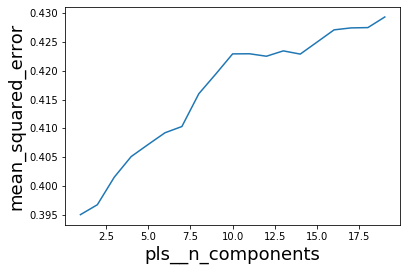

In [25]:
plt.plot(np.arange(1,20),-pls_grid_search.cv_results_["mean_test_score"])
plt.xlabel("pls__n_components", fontsize=18)
plt.ylabel("mean_squared_error", fontsize=18)
plt.show()

In [26]:
y_predictions_pls = pls_grid_search.predict(X_test_Standard)
test_mse_pls = mean_squared_error(y_test, y_predictions_pls)
test_mse_pls

0.4952824659309314

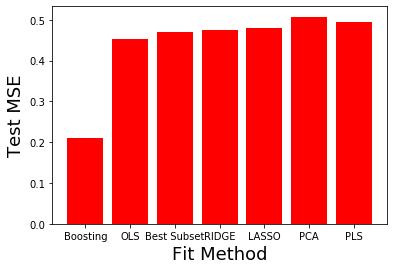

In [27]:
method_list = ['Boosting','OLS','Best Subset','RIDGE','LASSO','PCA','PLS']
MSE_list = [gb_test_mse_min,lin_test_mse,selector_test_mse,test_mse_ridge,test_mse_lasso,test_mse_pca,test_mse_pls]
plt.bar(method_list,MSE_list,color = 'red')
plt.xlabel("Fit Method", fontsize=18)
plt.ylabel("Test MSE", fontsize=18)
plt.show()

**(f) Which variables appear to be the most important predictors in
the boosted model?**

In [28]:
gb_reg = GradientBoostingRegressor(n_estimators = 1000,learning_rate=float(gb_test_mse.idxmin()),random_state = 1)
gb_reg.fit(X_train,y_train.values.flatten())

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.31622776601683794,
                          loss='ls', max_depth=3, max_features=None,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=1,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=1000, n_iter_no_change=None,
                          presort='deprecated', random_state=1, subsample=1.0,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)

In [29]:
feature_importance=pd.DataFrame({'feature':X_train.columns, 'importance':(gb_reg.feature_importances_ * 100).round(3)})
feature_importance.sort_values('importance',ascending=False)

,feature,importance
10,CAtBat,49.505
11,CHits,14.654
3,AtBat,7.203
12,CHmRun,5.675
14,CRBI,3.982
9,Years,3.048
15,CWalks,2.990
16,PutOuts,2.788
4,Hits,1.721
8,Walks,1.558


**(g) Now apply bagging to the training set. What is the test set MSE
for this approach?**

In [30]:
from sklearn.ensemble import RandomForestRegressor
bag_rf_reg = RandomForestRegressor(n_estimators=500,random_state=1,max_features = len(X_train.columns))
bag_rf_reg.fit(X_train,y_train.values.ravel())
test_mse_bagging = mean_squared_error(y_test,bag_rf_reg.predict(X_test))
test_mse_bagging

0.2504840838121538

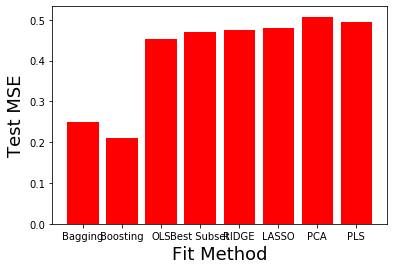

In [31]:
method_list = ['Bagging','Boosting','OLS','Best Subset','RIDGE','LASSO','PCA','PLS']
MSE_list = [test_mse_bagging,gb_test_mse_min,lin_test_mse,selector_test_mse,test_mse_ridge,test_mse_lasso,test_mse_pca,test_mse_pls]
plt.bar(method_list,MSE_list,color = 'red')
plt.xlabel("Fit Method", fontsize=18)
plt.ylabel("Test MSE", fontsize=18)
plt.show()

**Other:Compare the test MSE of boosting to the test MSE that results from applying the regression approaches seen in Chapters 7**

In [32]:
#先利用最优子集法数据确认哪些变量有相关
pd.DataFrame(selector.ranking_,index = X_train.columns).T

,League[T.N],Division[T.W],NewLeague[T.N],AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors
0,1,1,1,1,1,1,1,6,1,1,10,7,3,11,5,4,8,9,2


其中包含关系的定量变量为AtBat	Hits	HmRun	Runs Walks	Years 

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PolynomialFeatures
class CombinedPolyAll(BaseEstimator, TransformerMixin):
    def __init__(self,AtBat_degree = 2,Hits_degree= 2,HmRun_degree= 2,Runs_degree= 2, Walks_degree= 2,Years_degree= 2,
                 LeagueN_degree= 1,DivisionTW_degree= 1,NewLeagueTN_degree = 1): # no *args or **kargs
        self.AtBat_degree = AtBat_degree
        self.Hits_degree = Hits_degree
        self.HmRun_degree = HmRun_degree
        self.Runs_degree = Runs_degree
        self.Walks_degree = Walks_degree
        self.Years_degree = Years_degree
        self.LeagueN_degree = LeagueN_degree
        self.DivisionTW_degree = DivisionTW_degree
        self.NewLeagueTN_degree = NewLeagueTN_degree
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        factor_degrees = [self.AtBat_degree,self.Hits_degree,self.HmRun_degree,self.Runs_degree,self.Walks_degree,self.Years_degree,
                         self.LeagueN_degree,self.DivisionTW_degree,self.NewLeagueTN_degree]
        factor_columns_num = [4,5,6,7,9,10,0,1,2]
        for factor_num in range(len(factor_columns_num)):
            X_factor = X[:,factor_columns_num[factor_num]].reshape(-1, 1) 
            if factor_degrees[factor_num] > 0:
                poly_features = PolynomialFeatures(degree=factor_degrees[factor_num],include_bias=False)
                X_poly = poly_features.fit_transform(X_factor)
            else:
                X_poly = np.zeros_like(X_factor)
            if factor_num == 0:
                X_output = X_poly
            else:
                X_output = np.c_[X_output,X_poly]
        return X_output
    
cpa_lr = Pipeline([
("cpa", CombinedPolyAll()),
("lr", linear_model.LinearRegression())
])
param_grid = [
{'cpa__AtBat_degree': np.arange(0,4),
 'cpa__Hits_degree': np.arange(0,4),
 'cpa__HmRun_degree': np.arange(0,4),
 'cpa__Runs_degree': np.arange(0,4),
 'cpa__Walks_degree': np.arange(0,4),
 'cpa__Years_degree': np.arange(0,4),
 'cpa__LeagueN_degree': np.arange(0,1),
 'cpa__DivisionTW_degree': np.arange(0,1),
 'cpa__NewLeagueTN_degree': np.arange(0,1)
},
]
grid_search = GridSearchCV(cpa_lr, param_grid, cv = 10, scoring='neg_mean_squared_error')
grid_search.fit(X_train.values ,y_train.values)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cpa',
                                        CombinedPolyAll(AtBat_degree=2,
                                                        DivisionTW_degree=1,
                                                        Hits_degree=2,
                                                        HmRun_degree=2,
                                                        LeagueN_degree=1,
                                                        NewLeagueTN_degree=1,
                                                        Runs_degree=2,
                                                        Walks_degree=2,
                                                        Years_degree=2)),
                                       ('lr',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                 

In [34]:
grid_search.best_params_

{'cpa__AtBat_degree': 0,
 'cpa__DivisionTW_degree': 0,
 'cpa__Hits_degree': 0,
 'cpa__HmRun_degree': 0,
 'cpa__LeagueN_degree': 0,
 'cpa__NewLeagueTN_degree': 0,
 'cpa__Runs_degree': 1,
 'cpa__Walks_degree': 3,
 'cpa__Years_degree': 2}

In [35]:
test_mse_poly = mean_squared_error(y_test,grid_search.predict(X_test.values))
test_mse_poly

0.3463468684381249

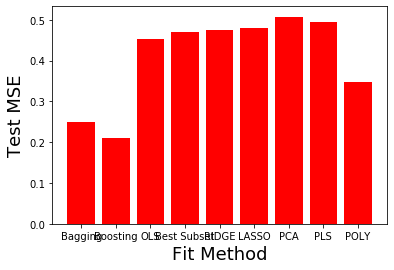

In [36]:
method_list = ['Bagging','Boosting','OLS','Best Subset','RIDGE','LASSO','PCA','PLS','POLY']
MSE_list = [test_mse_bagging,gb_test_mse_min,lin_test_mse,selector_test_mse,test_mse_ridge,test_mse_lasso,test_mse_pca,test_mse_pls,test_mse_poly]
plt.bar(method_list,MSE_list,color = 'red')
plt.xlabel("Fit Method", fontsize=18)
plt.ylabel("Test MSE", fontsize=18)
plt.show()

**可见多项式回归优于线性模型，但是比bagging和boosting还是有较大差距**